# INDIVIDUAL PLANNING STAGE:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In this project, I'd like to see what player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types. More specifically, if **hours played** and **age** predicts if a player **subscribes** in *players.csv*.

The dataset players.csv consists of the name, Age, and gender of the player, whether or not theyre subscribed, their hashed email, their experience, and the number of hours they played. 

In [2]:
players <- read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [13]:
avg_age <- players |>
    summarize(mean_age = mean(Age, na.rm = TRUE)) |>
    round(2)

avg_hours <- players |>
    summarize(mean_hours = mean(played_hours)) |>
    round(2)

total_subscribed <- players |>
    filter(subscribe == TRUE) |>
    summarize(total_subscribed = n())

players_with_0.2_hrs_or_less <- players |>
    filter(played_hours < 0.3) |>
    summarize(Less_than_0.3_hrs = n())

Median_age <- players |>
    summarize(Median_age = median(Age, na.rm = TRUE))

Median_hours <- players |>
    summarize(Median_hours = median(played_hours, na.rm = TRUE))

Total <- players |>
    summarize(total_players = n())

tibble(Total, total_subscribed, players_with_0.2_hrs_or_less, avg_hours, Median_hours, avg_age, Median_age,)

total_players,total_subscribed,Less_than_0.3_hrs,mean_hours,Median_hours,mean_age,Median_age
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
196,144,129,5.85,0.1,21.14,19


The total number of players is 196, while total subscribed is 144.

A few issues seen is that the median playtime is very small (0.1), and 129/196, or 66% of people played for 0.2hrs (12 mins) or less, so the prediction might be innacurate as theres a quite small amount of variance. There are also a few players who have their age as **NA**, so this should be accounted for while wrangling the data.

Warning message:
“Removed 74 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message in scale_x_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_bar()`).”


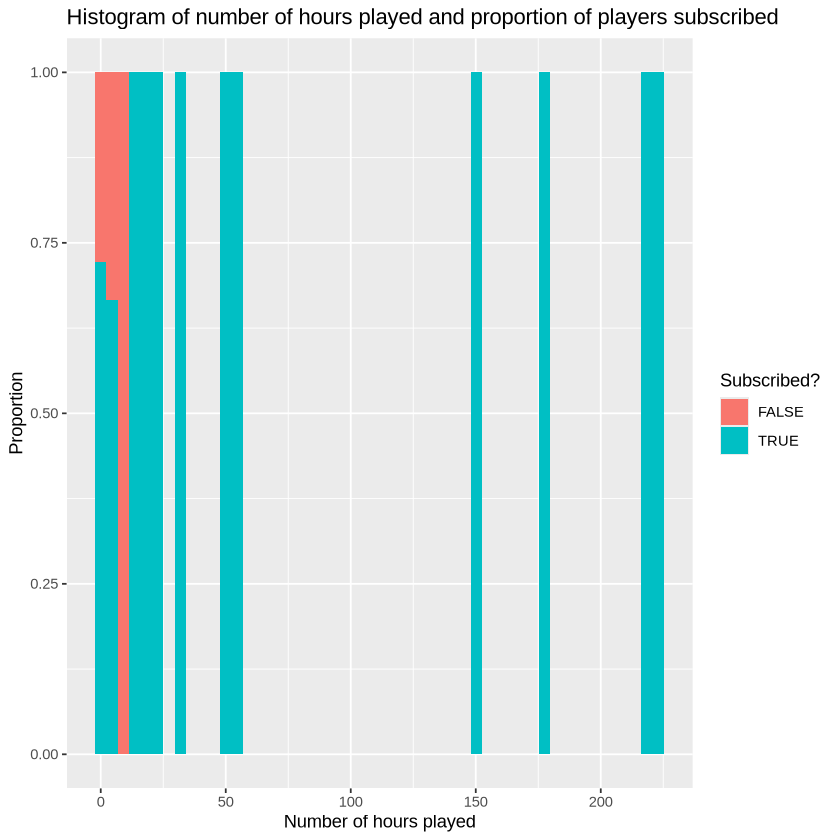

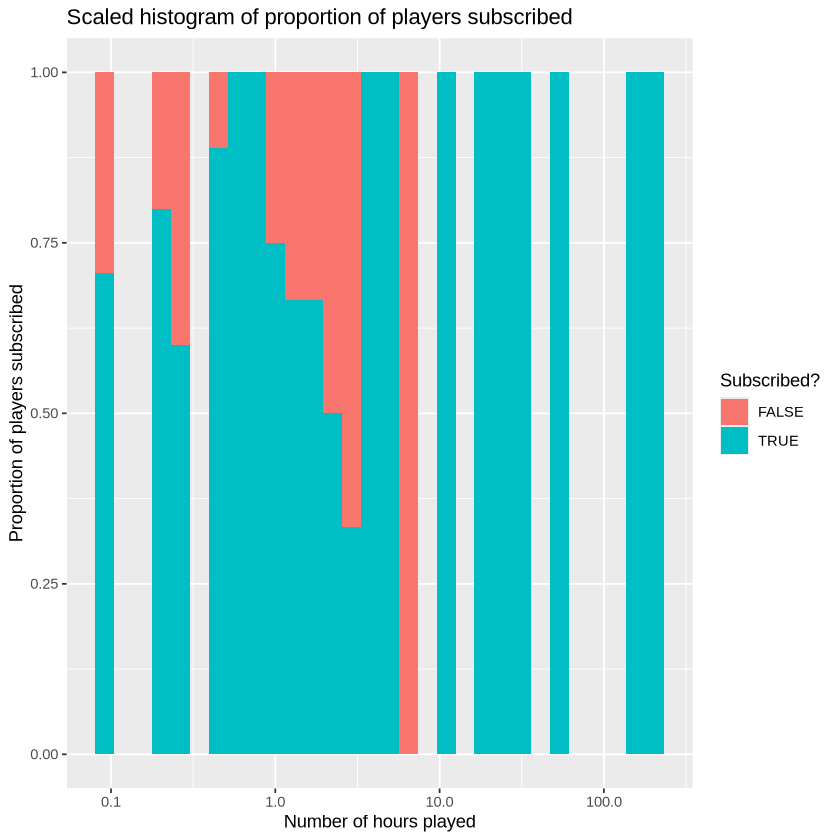

In [4]:
graph_hours <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(position = "fill", bins = 50) +
        labs(x = "Number of hours played", y = "Proportion", fill = "Subscribed?") +
        ggtitle("Histogram of number of hours played and proportion of players subscribed")
graph_hours

scaled_graph_hours <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(position = "fill", bins = 30) +
        labs(x = "Number of hours played", y = "Proportion of players subscribed", fill = "Subscribed?") +
        scale_x_log10(labels = label_comma()) +
        ggtitle("Scaled histogram of proportion of players subscribed")
scaled_graph_hours

We can clearly see that every player that has 10 or more hours played is subscribed. However, weirdly enough, between 0:10, it seems like the proportional of people subscribed falls more and more as we get closer to 10. Now firstly, lets see how many people have more than 10 hours played as it could just be a small number.

In [12]:
players_more_than_10 <- players |>
    filter(played_hours >=10) |>
    count() |>
    pull()
players_more_than_10

[1] 13

There are only 13 players with 10 or more hours, this is only 13/196, or 6.6% of the players. Therefore, its not conclusive enough to say anything. We'll keep this in mind and filter them out for now.

Warning message:
“Removed 26 rows containing missing values or values outside the scale range
(`geom_bar()`).”


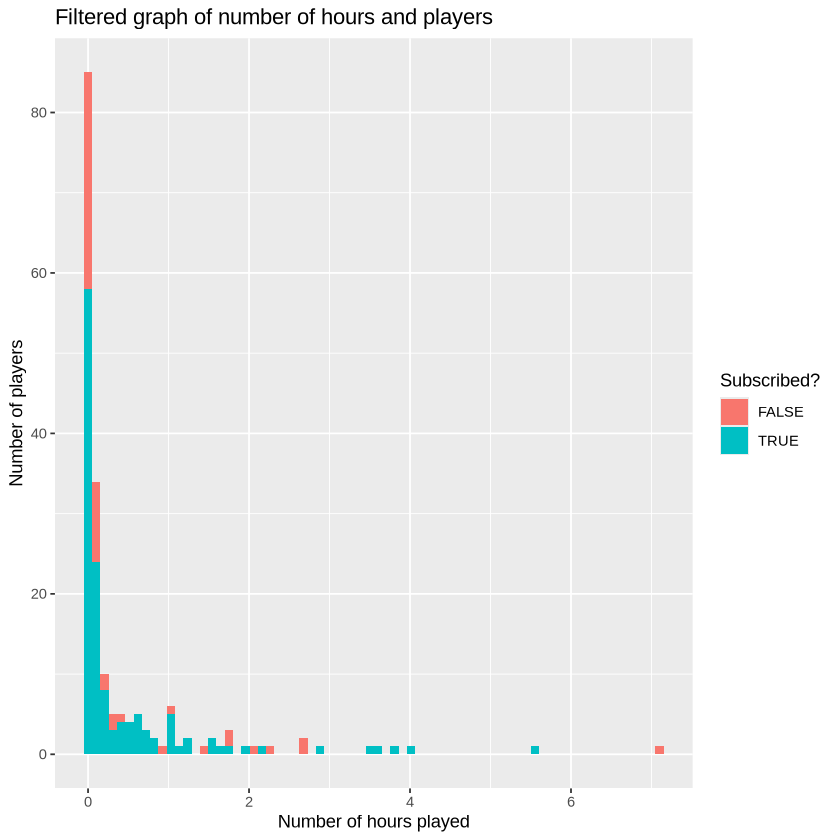

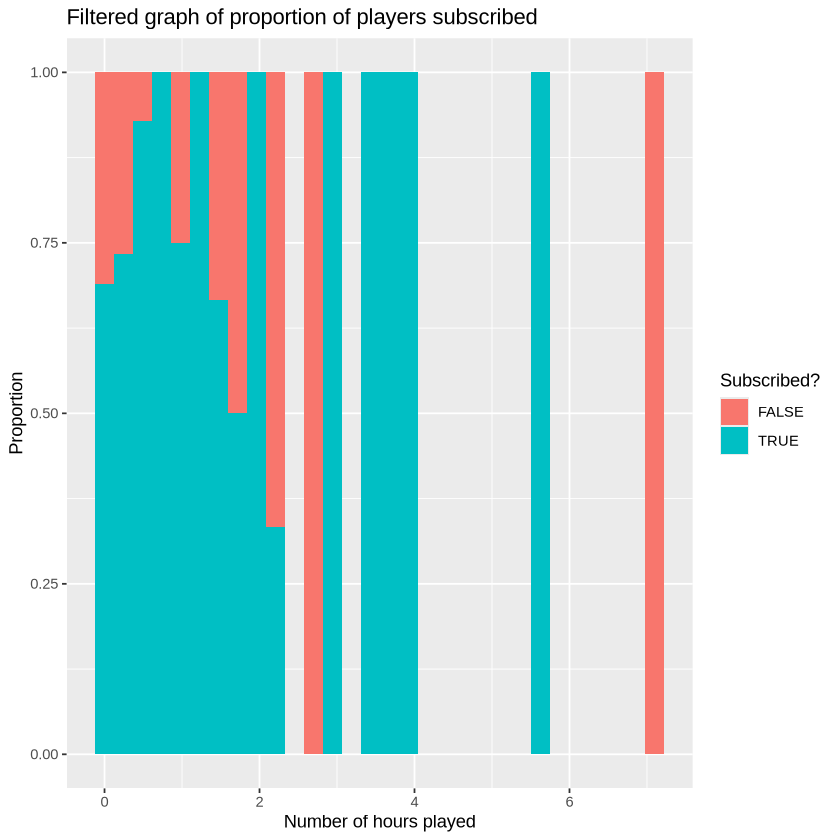

In [18]:
filtered_graph_hours <- players |>
    filter(played_hours < 10) |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(bins = 70) +
        labs(x = "Number of hours played", y = "Number of players", fill = "Subscribed?") +
        ggtitle("Filtered graph of number of hours and players")
filtered_graph_hours

filtered_graph_hours <- players |>
    filter(played_hours < 10) |>
    ggplot(aes(x = played_hours, fill = subscribe)) + 
        geom_histogram(position = "fill", bins = 30) +
        labs(x = "Number of hours played", y = "Proportion", fill = "Subscribed?") +
        ggtitle("Filtered graph of proportion of players subscribed")
filtered_graph_hours

Looking at this data, there does not seem to be much of a direct correlation between number of hours played and whether they subscribe, so this probably wont be a linear model.

Now, lets also quickly visualize age and subscription.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_bar()`).”


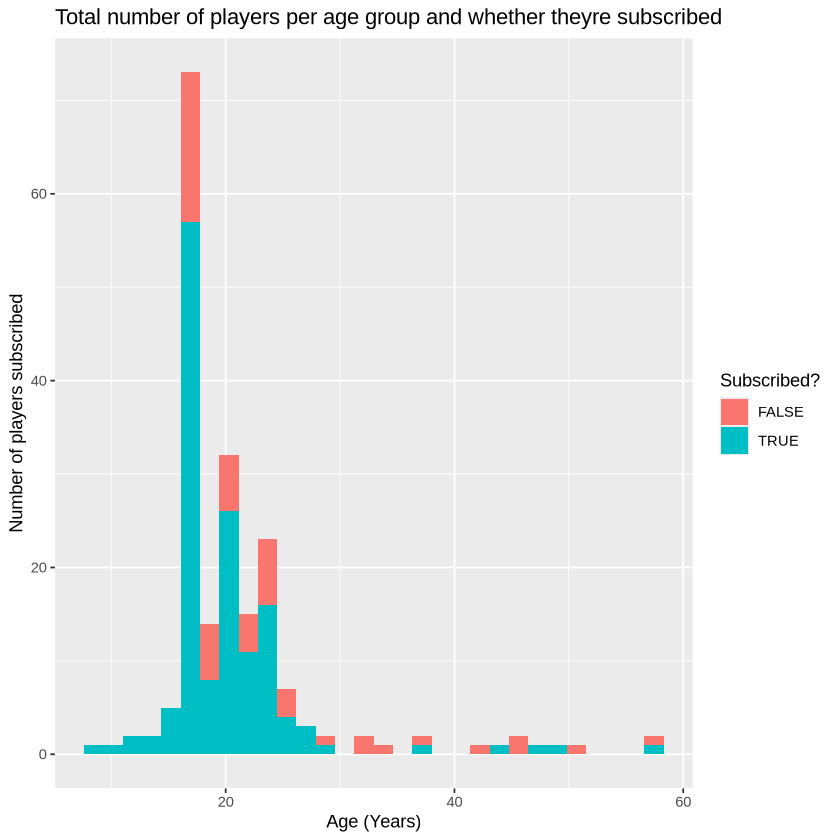

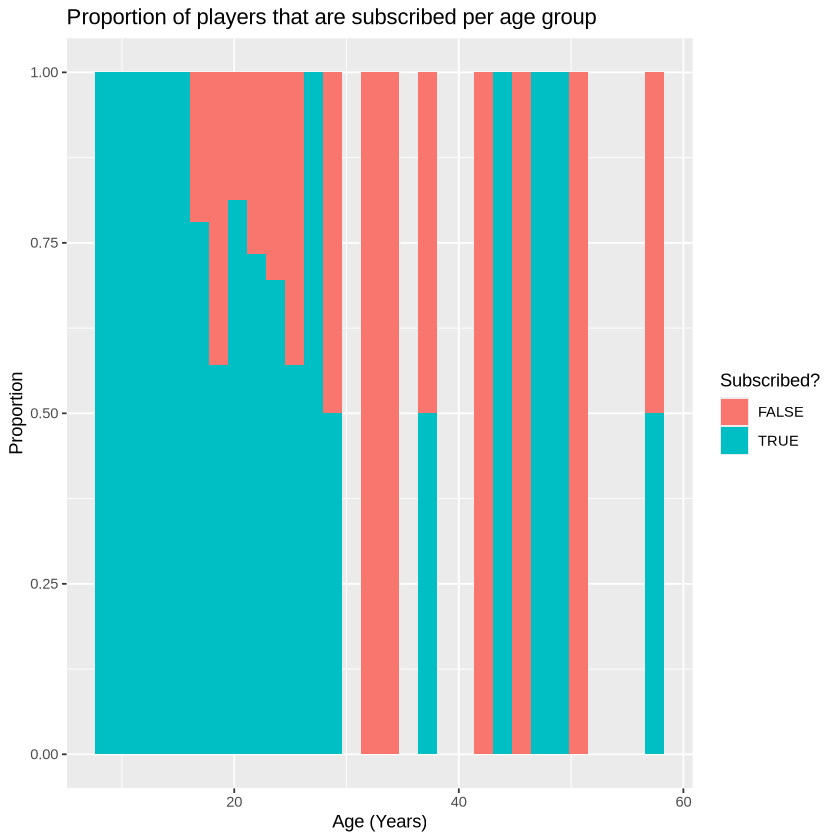

In [8]:
gender_graph <- players |>
    ggplot(aes(x = Age, fill = subscribe)) +
        geom_histogram(bins = 30) +
        labs(x = "Age (Years)", y = "Number of players subscribed", fill = "Subscribed?") +
        ggtitle("Total number of players per age group and whether theyre subscribed")
gender_graph

gender_graph <- players |>
    ggplot(aes(x = Age, fill = subscribe)) +
        geom_histogram(position = "fill", bins = 30) +
        ggtitle("Proportion of players that are subscribed per age group") +
        labs(x = "Age (Years)", y = "Proportion", fill = "Subscribed?")
gender_graph

We can see that on average, the younger players seem to subscribe more than older players.

And to put this together into a scatter plot:

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


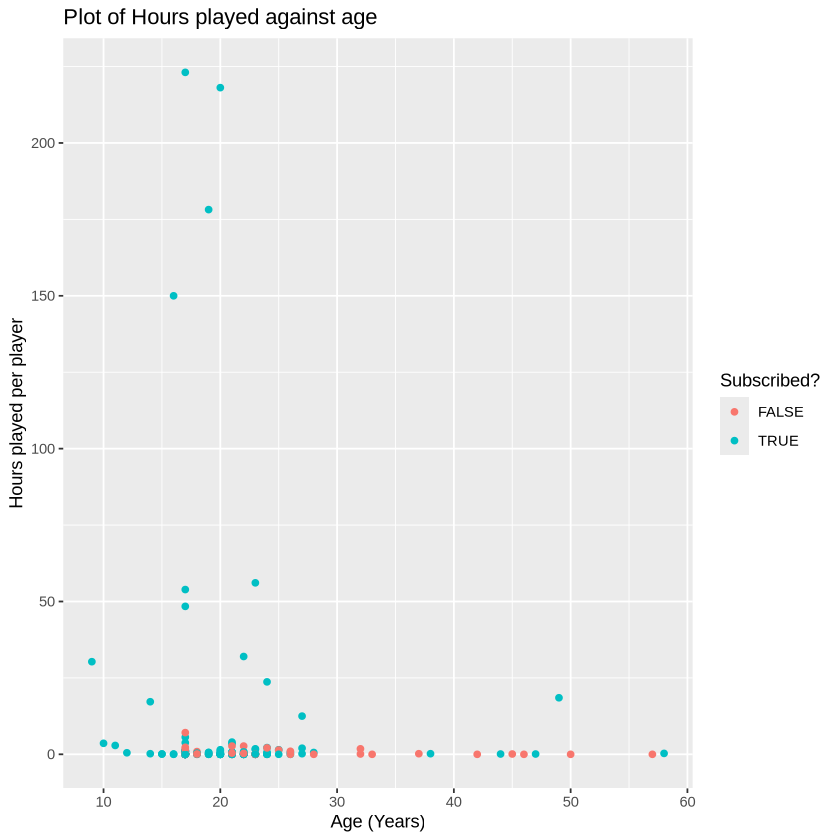

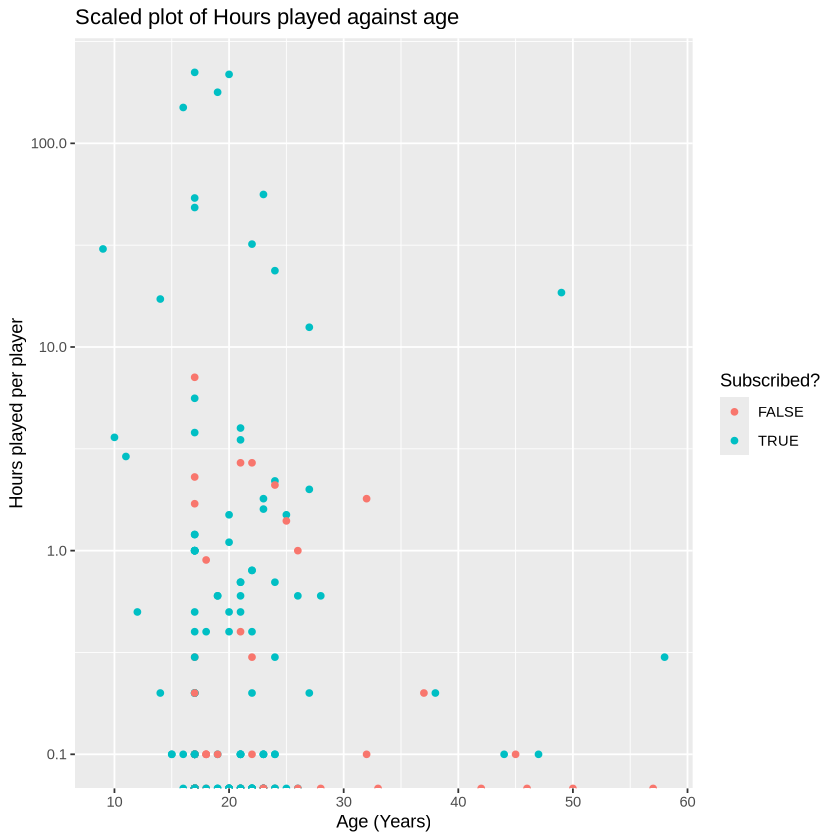

In [9]:
both_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
        geom_point() +
        labs(x = "Age (Years)", y = "Hours played per player", color = "Subscribed?") +
        ggtitle("Plot of Hours played against age")
both_plot

scaled_both_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
        geom_point() +
        scale_y_log10() +
        labs(x = "Age (Years)", y = "Hours played per player", color = "Subscribed?") +
        ggtitle("Scaled plot of Hours played against age")
scaled_both_plot

So, this will be a **k-nn classification** problem, where **Age** and **played_hours** will be the predictive variables for **subscribe**. An issue with k-nn is that it will not perform great when played_hours or Age gets too large as it doesnt do too well with extrapolating. There also arent too many players older than 30 so the model wont predict those too well. We'll also have to standardize the data as the range of values of played_hours can be is much greater than Age. 

Another issue is that for example, take (20,0.1), and k=3, if one of the 2 further away FALSE points were TRUE (imagining this data is standardized), then it would have 2 points of equal distance but opposite classification, making it a coin flip basically.

We'll do a 75/25 initial split, and then use **5 folds** for cross validation for the training set, making sure that each time we split we get an equal amount of variance in the data, then train the model on the training set, and test it on the testing set to get the accuracy and see how well it performs. This will help us conclude whether or not played hours and age can predict if a player subscribes.